<a href="https://colab.research.google.com/github/yuzhounaut/SpaceM/blob/master/SpaceM_single_cell_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook presents the code used to generate the figures presented in the SpaceM paper. All datasets presented in the paper are available on [MetaboLights](https://www.ebi.ac.uk/metabolights/descriptors).

# Initial setup

Mount your Google drive on Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Add [this folder](https://drive.google.com/drive/folders/1q1viBTx4Qt-_eeD8t8L85S8b25KvnzfB?usp=sharing) to your google drive. On the path, click on 'SpaceM_GCollab' then 'Add shortcut to Drive'

Install Scanpy

In [ ]:
!pip install scanpy[leiden]
!pip install umap-learn
!pip install bbknn

In [ ]:
from scipy.stats import spearmanr, ttest_ind
import umap
import seaborn as sns
import pandas as pd
import numpy as np
import os, re, glob
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Read SpaceM spatio-molecular matrices and perform the single-analysis pipeline

## Co-culture dataset


Read SpaceM output

In [ ]:
df0 = pd.read_csv('/content/gdrive/My Drive/SpaceM_GCollab/SpaceM_Paper_pseudotime_analysis/Co-culture_SpaceM_output.csv')
mols = ['C10H14N5O7P', 'C10H17N3O6S', 'C11H11ClN2O2', 'C16H30O2', 'C18H13NO4', 'C18H32O2', 'C18H34O2', 'C18H36O2', 'C19H37O6P',
        'C19H37O7P', 'C19H39O7P', 'C20H30O2', 'C20H32O2', 'C20H34O2', 'C21H37O6P', 'C21H39O6P', 'C21H39O7P', 'C21H41O6P',
        'C21H41O7P', 'C21H43O7P', 'C21H44NO6P', 'C21H44NO7P', 'C22H30N2O5', 'C22H32O2', 'C22H34O2', 'C23H43O7P', 'C23H46NO7P',
        'C23H48NO7P', 'C25H44NO7P', 'C25H50NO7P', 'C27H44NO7P', 'C27H46NO7P', 'C27H48NO7P', 'C27H51O12P', 'C27H53O12P',
        'C29H49O12P', 'C30H39N3O7', 'C34H68NO6P', 'C35H67O8P', 'C35H69O8P', 'C36H69O8P','C37H69O8P', 'C37H71O8P',
        'C37H74NO8P', 'C38H71O8P', 'C38H73O8P', 'C39H69O8P', 'C39H71O8P','C39H73O8P', 'C39H74NO8P', 'C39H75O8P',
        'C39H76NO8P', 'C40H76NO10P', 'C40H77O10P', 'C40H78NO8P', 'C41H71O8P', 'C41H73O8P', 'C41H74NO7P', 'C41H74NO8P',
        'C41H75O8P', 'C41H78NO8P', 'C41H80NO8P', 'C42H80NO10P', 'C42H82NO6P', 'C43H73O8P', 'C43H75O8P',  'C43H76NO7P',
        'C43H76NO8P', 'C43H78NO7P', 'C43H78NO8P', 'C43H79O13P', 'C43H81O13P', 'C43H82NO8P', 'C44H78NO10P', 'C44H84NO6P',
        'C45H78NO8P', 'C45H79O13P', 'C45H80NO8P', 'C45H81O13P', 'C45H82NO8P', 'C47H81O13P', 'C47H85O13P', 'C5H14NO6P',
        'C6H11O8P', 'C6H13O7P', 'C6H13O9P', 'C6H14NO7P', 'C9H19O11P']

adduct = '-H'


Analyze both replicates indepently with scanpy

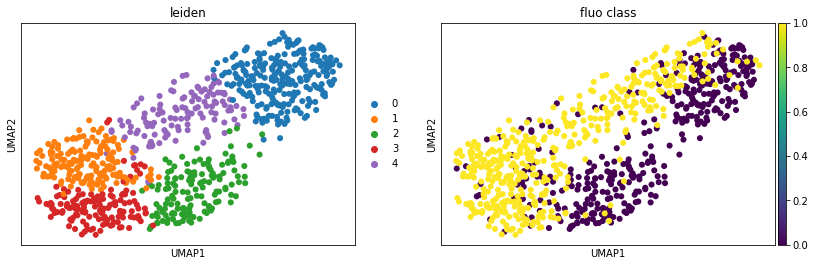

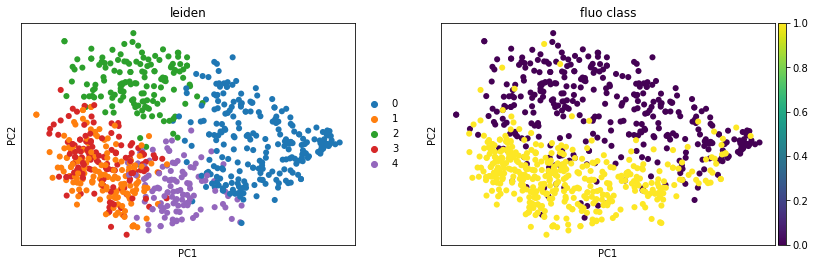

In [ ]:
def process(adata, resolution):
    sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)

    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.neighbors(adata, n_neighbors=25, metric='cosine')  # , use_rep='X')
    sc.tl.umap(adata, min_dist=0.5)  # , init_pos=adata.obsm['X_pca'])
    sc.tl.leiden(adata, resolution=resolution)

    sc.pl.umap(adata, color=['leiden', 'fluo class'])
    sc.pl.pca(adata, color=['leiden', 'fluo class'])

df1 = df0[df0['ds'] == 'c2_neg'].reset_index()
X1 = 10 ** (df1.loc[:, mols].values) - 1
adata = anndata.AnnData(X1)
adata.obs['fluo class'] = df1['fluo_cluster'].values
process(adata, resolution = 0.9)

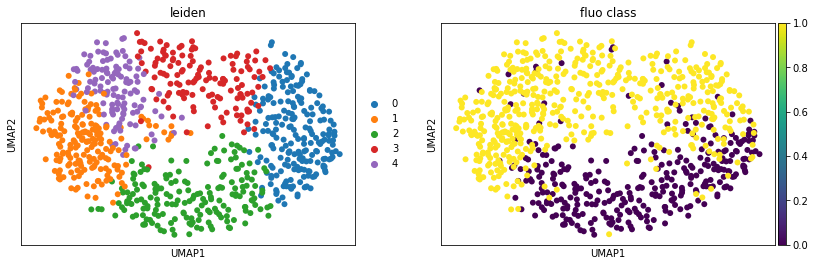

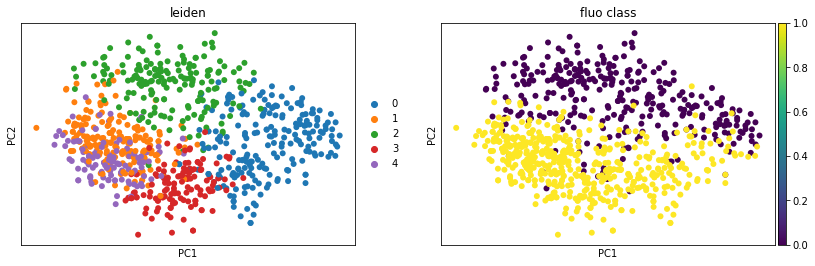

In [ ]:
df2 = df0[df0['ds'] == 'c4_neg'].reset_index()
X2 = 10 ** (df2.loc[:, mols].values) - 1
adata_ref = anndata.AnnData(X2)
adata_ref.obs['fluo class'] = df2['fluo_cluster'].values
process(adata_ref, resolution = 1)

Concatenate both datasets


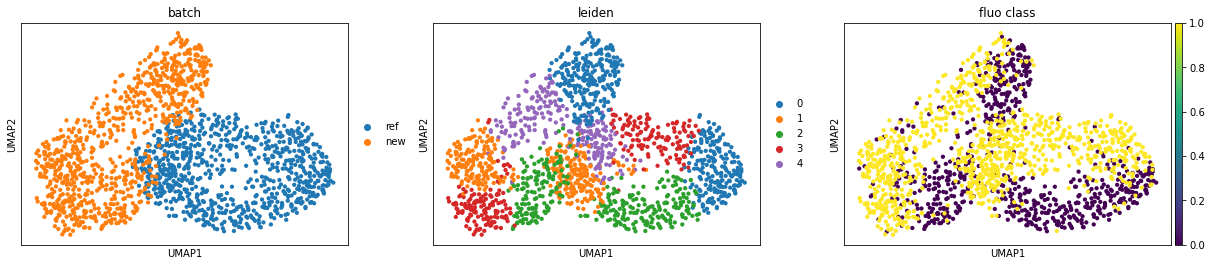

In [ ]:
adata.uns['leiden_colors'] = adata_ref.uns['leiden_colors']  # fix colors
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])
adata_concat.obs.leiden = adata_concat.obs.leiden.astype('category')
adata_concat.obs.leiden.cat.reorder_categories(adata_ref.obs.leiden.cat.categories,
                                               inplace=True)  # fix category ordering
adata_concat.uns['leiden_colors'] = adata_ref.uns['leiden_colors']  # fix category colors

sc.pl.umap(adata_concat, color=['batch', 'leiden', 'fluo class'])

Integrate both datasets with BBkNN

/usr/local/lib/python3.6/dist-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/usr/local/lib/python3.6/dist-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


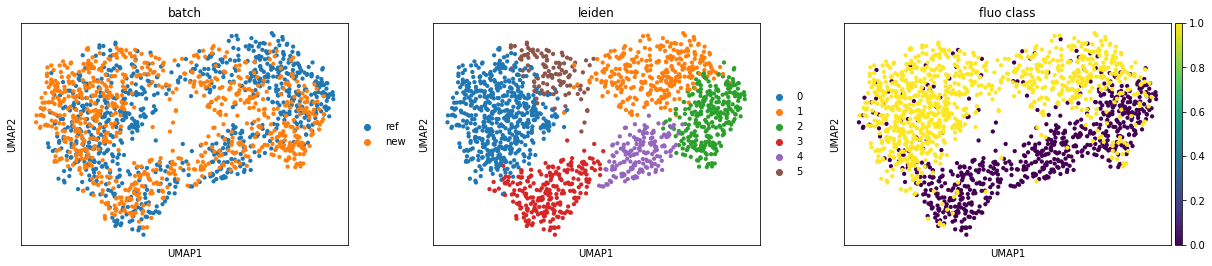

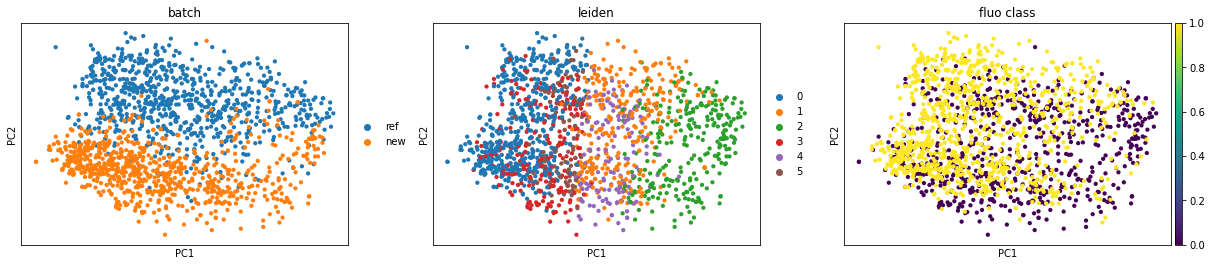

In [ ]:
sc.tl.pca(adata_concat)
sc.external.pp.bbknn(adata_concat, batch_key='batch')
sc.tl.umap(adata_concat)
sc.tl.leiden(adata_concat, resolution=0.6)
sc.pl.umap(adata_concat, color=['batch', 'leiden', 'fluo class'])
sc.tl.pca(adata_concat)
sc.pl.pca(adata_concat, color=['batch', 'leiden', 'fluo class'])

# A copy of adata_concat is saved in the google drive folder uner the name 
# of Co-cutlure_checkpoint.h5ad

## Hepatocyte datasets

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/SpaceM_GCollab/SpaceM_Paper_pseudotime_analysis/Hepatocytes_SpaceM_output.csv')

Create names for the metabolites, containing the annotation, sum formula and adduct

In [ ]:
on_mol = pd.read_csv('/content/gdrive/My Drive/SpaceM_GCollab/SpaceM_Paper_pseudotime_analysis/ON_sample_annotations.csv')
on_mol_arr = on_mol['sf'].values + ',' + on_mol['adduct'].values
mol_names = pd.read_csv(r'/content/gdrive/My Drive/SpaceM_GCollab/SpaceM_Paper_pseudotime_analysis/Metabolite_names.csv')
mol_names['compact'] = mol_names['sf'].values + ',' + mol_names['adduct'].values

var_names = []
for i in range(len(on_mol)):
    sf = on_mol.loc[i, 'sf']
    adduct = on_mol.loc[i, 'adduct']
    ann = mol_names[mol_names['sf'] == sf][mol_names['adduct'] == adduct]['annotation'].values[0]
    if len(ann) > 15:
        ann = 'name_too_long'
    var_names.append(ann + f' {sf}, {adduct}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


Convert the matrix into an anndata object for scpany analysis

In [ ]:
adata = anndata.AnnData(df.loc[:, on_mol_arr].values)
adata.var_names = var_names

# Add fields to adata
field = 'Intensity_MeanIntensity_OrigRed_highDR'
pc = 5
color_data = np.log10(np.nan_to_num(df[field].values) + 1 * 2 ** 16)
color = np.clip(color_data, np.percentile(color_data, pc), np.percentile(color_data, 100 - pc))
adata.obs['dataset'] = df['ds'].values
adata.obs['condition'] = df['cond'].values
adata.obs['fluo_data'] = color_data
adata.obs['fluo'] = color

Filter cells, normalize and log transform

In [ ]:
sc.pp.filter_cells(adata, min_genes=5)
sc.pp.normalize_total(adata, target_sum=None)
adata.raw = adata #Keep raw intensities for calcualtions
sc.pp.log1p(adata)

Perform batch correction condition-wise


In [ ]:
adata_U = adata[adata.obs['condition'] == 'U', :]
sc.pp.combat(adata_U, key='dataset')

adata_F = adata[adata.obs['condition'] == 'F', :]
sc.pp.combat(adata_F, key='dataset')

adata_FI = adata[adata.obs['condition'] == 'FI', :]
sc.pp.combat(adata_FI, key='dataset')

adata_FIT = adata[adata.obs['condition'] == 'FIT', :]
sc.pp.combat(adata_FIT, key='dataset')

adata_concat = adata_U.concatenate(adata_F, adata_FI, adata_FIT)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical


Found 69 genes with zero variance.


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical


Compute the PCA and neighbor graph for leiden clustering 

... storing 'dataset' as categorical
... storing 'condition' as categorical


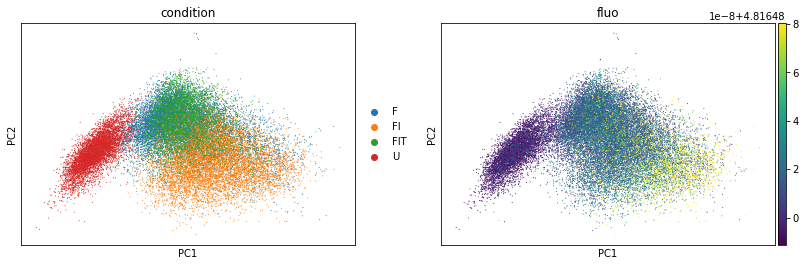

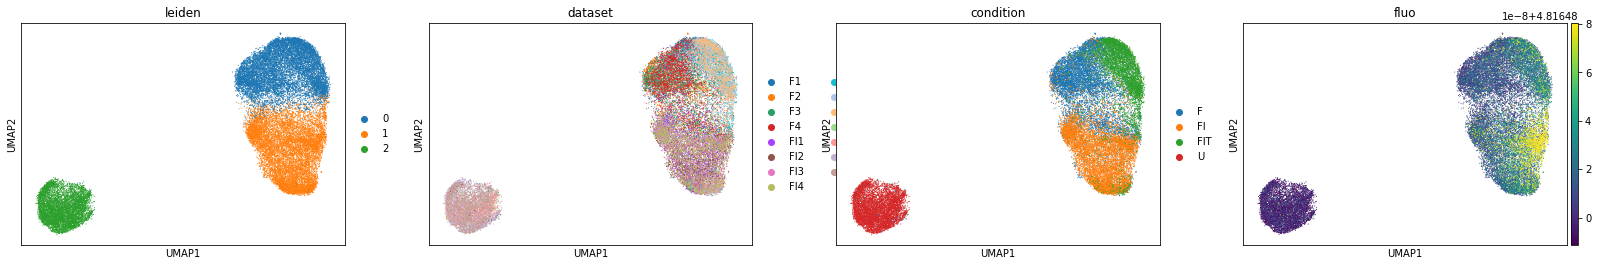

In [ ]:
sc.tl.pca(adata_concat, svd_solver='arpack')
sc.pl.pca(adata_concat, color=['condition', 'fluo'])
sc.pp.scale(adata_concat, max_value=None)

sc.pp.neighbors(adata_concat, n_neighbors=25, metric='cosine')#, use_rep='X')

sc.tl.leiden(adata_concat, resolution=0.4)
sc.tl.umap(adata_concat, min_dist=0.1)
sc.pl.umap(adata_concat, color=['leiden', 'dataset', 'condition', 'fluo'])

Compute PAGA layout and FA2 embedding

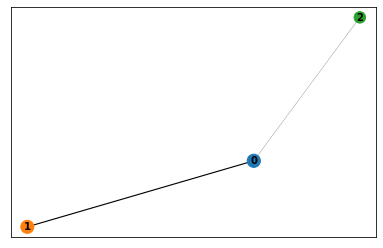

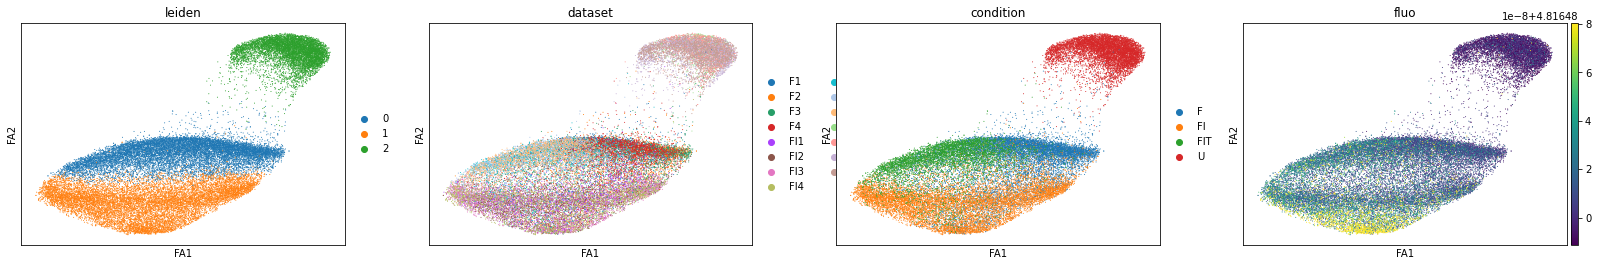

In [ ]:
sc.tl.paga(adata_concat, groups='leiden')
sc.pl.paga(adata_concat, layout='fa', init_pos=adata_concat.obsm['X_umap'])
sc.tl.draw_graph(adata_concat, init_pos='paga')
sc.pl.draw_graph(adata_concat, color=['leiden', 'dataset', 'condition', 'fluo'])

# A copy of adata_concat is saved in the google drive folder uner the name 
# of Hepatocytes_checkpoint.h5ad. The order and colors of the clusters have been 
# modified for the paper clarity

# Classify HeLa and NIH3T3 cell types using SpaceM


Load the Co-culture SpaceM dataset


In [ ]:
adata = sc.read_h5ad('/content/gdrive/My Drive/SpaceM_GCollab/SpaceM_Paper_pseudotime_analysis/Co-cutlure_checkpoint.h5ad')

/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


... storing 'leiden_curated' as categorical


Classification accuracy = 0.8700120918984281


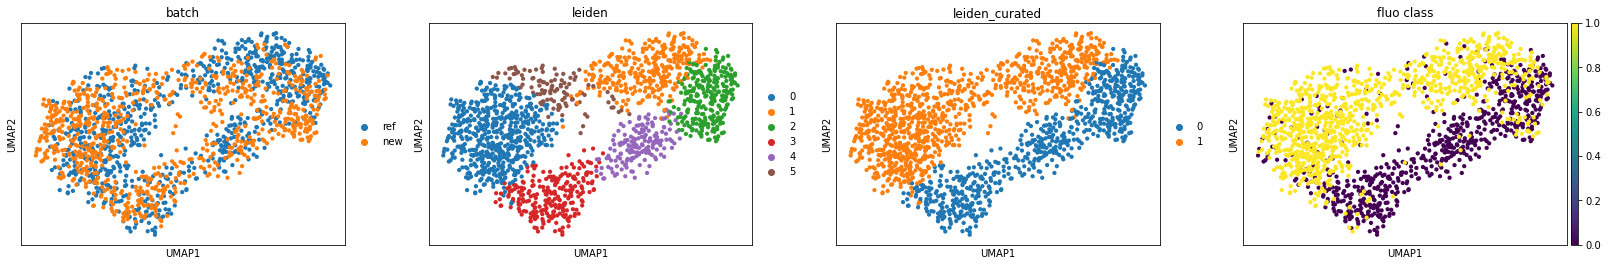

Text(0.5, 1.0, 'UMAP leiden_curated cluster labels')

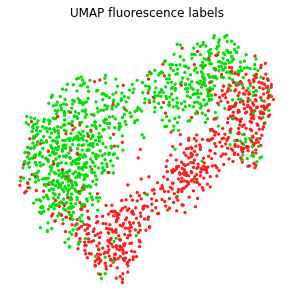

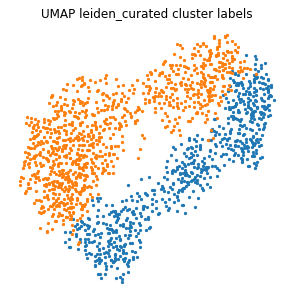

In [ ]:
# TODO barplot of fluo for each cluster

# Merge clusters of the same majoritary cell type together
leiden = np.array(adata.obs['leiden'].values)
leiden_curated = np.copy(leiden)
fc = np.array(adata.obs['fluo class'].values)
for cluster in np.unique(leiden):
    labels, counts = np.unique(fc[leiden == cluster], return_counts=True)
    leiden_curated[leiden == cluster] = str(labels[counts == np.max(counts)][0])
adata.obs['leiden_curated'] = leiden_curated

# Print accuracy
lc_int = np.array([int(i) for i in leiden_curated])
fc = np.array(adata.obs['fluo class'].values)
print('Classification accuracy = {}'.format(accuracy_score(y_true=fc, y_pred=lc_int)))
sc.pl.umap(adata,  color=['batch', 'leiden', 'leiden_curated', 'fluo class'])

# Make figures
xy_umap = adata.obsm['X_umap']
clusters = np.array([int(i) for i in np.array(adata.obs['leiden_curated'].values)])
fluo_labels = [int(i) for i in np.array(adata.obs['fluo class'].values)]
fluo_colors = [[255/255, 30/255, 30/255],
               [0/255, 220/255, 0/255]]
fluo_color_array = [fluo_colors[i] for i in fluo_labels]

plt.figure(figsize=(5, 5))
plt.scatter(xy_umap[:, 0], xy_umap[:, 1], 5, fluo_color_array)
plt.axis('off')
plt.title('UMAP fluorescence labels')

plt.figure(figsize=(5, 5))
plt.scatter(xy_umap[clusters==0, 0], xy_umap[clusters==0, 1], 5)
plt.scatter(xy_umap[clusters==1, 0], xy_umap[clusters==1, 1], 5)
plt.axis('off')
plt.title('UMAP leiden_curated cluster labels')

# Identify the steatotic metabolic state within a population of HepaRGs 

Load the Hepatocytes SpaceM data

In [ ]:
adata_all = sc.read_h5ad('/content/gdrive/My Drive/SpaceM_GCollab/SpaceM_Paper_pseudotime_analysis/Hepatocytes_checkpoint.h5ad')

/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


Normalize, log and scale the data

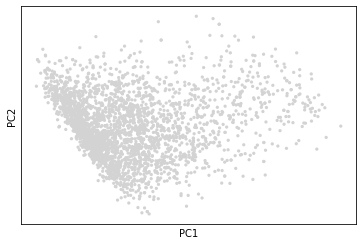

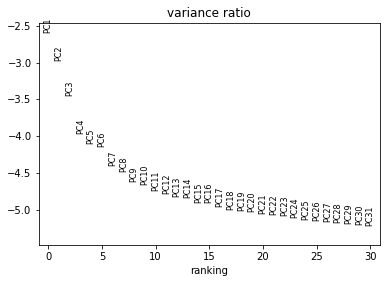

In [ ]:
adata = anndata.AnnData(X=adata_all.raw.X[adata_all.obs['dataset'] == 'F4', :],
                        obs=adata_all[adata_all.obs['dataset'] == 'F4', :].obs.loc[:,
                            ['condition', 'dataset', 'fluo', 'fluo_data']]
                        )

adata.var_names = adata_all.var_names
sc.pp.normalize_total(adata, target_sum=None)
adata.raw = adata
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.scale(adata, max_value=None)

Compute UMAP

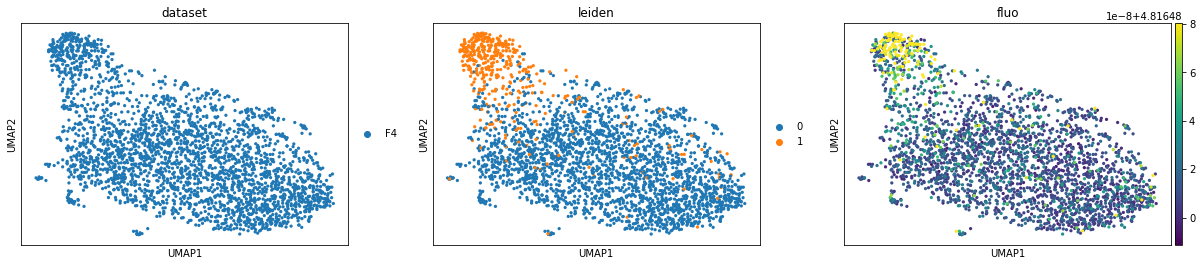

In [ ]:
reducer = umap.UMAP(metric='cosine', 
                    min_dist=0.2, 
                    n_neighbors=100)

embedding = reducer.fit_transform(adata.X)
adata.obsm['X_umap'] = embedding

sc.pp.neighbors(adata, n_neighbors=10, metric='cosine')
sc.tl.leiden(adata, resolution=0.2)
sc.pl.umap(adata, color=['dataset', 'leiden', 'fluo'])

# sc.pl.umap(adata, color=['dataset', 'condition', 'fluo'])

Plot fluorescence intensities between states

t-test p-value = 4.286553671189186e-167


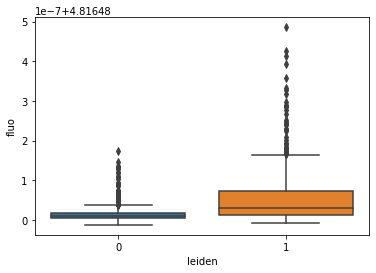

In [ ]:
def void2array(void):
    return pd.DataFrame(void).values

leiden = void2array(adata.obs['leiden'].values).ravel()
fluo_leiden_0 = adata.obs['fluo'][adata.obs['leiden'] == '0'].values
fluo_leiden_1 = adata.obs['fluo'][adata.obs['leiden'] == '1'].values

plt.figure()
bxp = pd.DataFrame()
bxp.loc[:, 'fluo'] = np.array(adata.obs['fluo_data'].values, dtype='float')
bxp.loc[:, 'leiden'] = adata.obs['leiden'].values
sns.boxplot(x='leiden', y='fluo', data=bxp)

print(f't-test p-value = {ttest_ind(fluo_leiden_0, fluo_leiden_1)[1]}')

Compute correlation of each metabolite with the lipid droplet stain LD540

In [ ]:
mol_names = pd.read_csv('/content/gdrive/My Drive/SpaceM_GCollab/SpaceM_Paper_pseudotime_analysis/Metabolite_names.csv')
mol_names['compact'] = mol_names['sf'].values + ', ' + mol_names['adduct'].values

fluo_values = adata.obs['fluo_data'].values
var_names = adata.var_names

corr_df = pd.DataFrame()
for i, name in enumerate(var_names):
    ion_values = adata.raw.X[:, i]

    mol_class = mol_names[mol_names['compact'] == ' '.join(name.split(' ')[-2:])]['class'].values[0]
    adduct = name.split(' ')[-1]

    if mol_class in ['PC', 'PE']:
        mol_class = 'PE / PC'

    if mol_class in ['TG', 'DG']:
        if adduct not in ['+H', '+K']:
            corr_df.loc[i, 'var_name'] = name
            corr_df.loc[i, 'class'] = mol_class
            corr_df.loc[i, 'annotation'] = mol_names[mol_names['compact'] == ' '.join(name.split(' ')[-2:])]['annotation'].values[0]
            corr_df.loc[i, 'var_name'] = name
            corr_df.loc[i, 'SpearmanR'] = np.nan_to_num(spearmanr(ion_values, fluo_values)[0])

    else:
        corr_df.loc[i, 'var_name'] = name
        corr_df.loc[i, 'class'] = mol_class
        corr_df.loc[i, 'annotation'] = \
        mol_names[mol_names['compact'] == ' '.join(name.split(' ')[-2:])]['annotation'].values[0]
        corr_df.loc[i, 'var_name'] = name
        corr_df.loc[i, 'SpearmanR'] = np.nan_to_num(spearmanr(ion_values, fluo_values)[0])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Color-code UMAP with the most correlating and anti-correlating metabolites

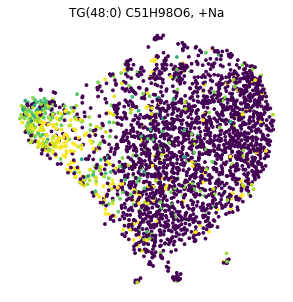

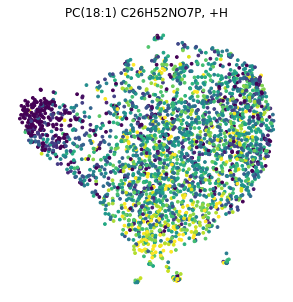

In [ ]:
def plot_umap_color(corr_df, field):
    plt.figure(figsize=(5, 5))
    plt.scatter(umap_data[:, 0], umap_data[:, 1], 7.5,
                contrast(adata.X[:, list(adata.var_names).index(field)], 10, 95))
    plt.title(field)
  
def contrast(arr, low, high):
    return np.clip(arr, np.percentile(arr, low), np.percentile(arr, high))

umap_data = adata.obsm['X_umap']
fieldS = ['TG(48:0) C51H98O6, +Na', 'PC(18:1) C26H52NO7P, +H']
for f in fieldS:
    plot_umap_color(corr_df, field = f)
    plt.axis('off')

Show the correlation of all detected molecules, grouped by class

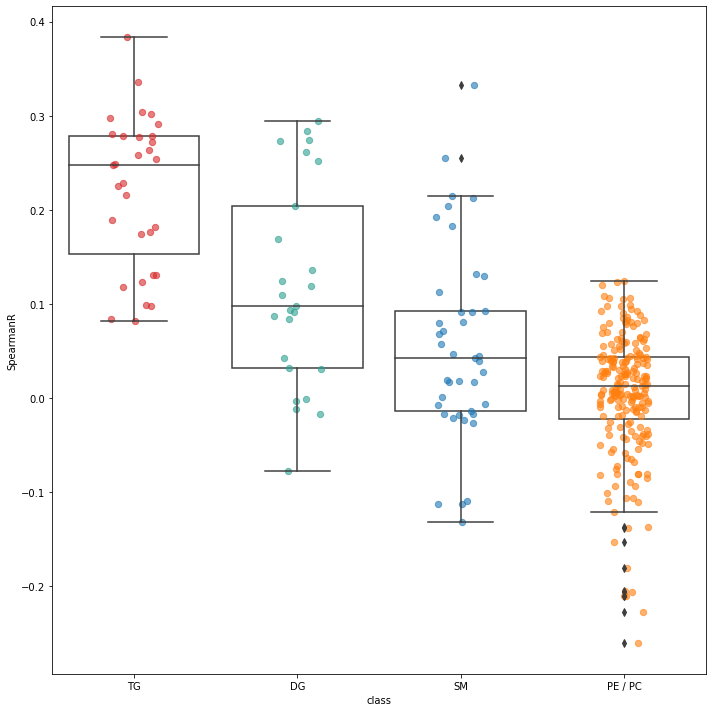

In [ ]:
classes = ['SM', 'PE / PC', 'DG', 'TG']
colors=np.array([[31, 119, 180], # Change
        [255, 127, 14], # Change
        [44, 160, 144],
        [214, 39, 40],
        [148, 103, 189],
        [140, 86, 75],
        [227, 119, 194],
        [31, 119, 180],
        [255, 127, 14]])
colors = [c/255 for c in colors]

medians = [np.median(corr_df[corr_df['class'] == cl]['SpearmanR']) for cl in classes]
sort_i = np.argsort(medians)
order = [classes[i] for i in reversed(sort_i)]
color_sorted = [colors[i] for i in reversed(sort_i)]

plt.figure(figsize=(10, 10))
for i in sort_i:
    mols = corr_df[corr_df['class'] == order[i]]['SpearmanR'].values
    names = corr_df[corr_df['class'] == order[i]]['annotation'].values
    x = np.random.uniform(i - 0.15, i + 0.15, size=np.shape(mols))
    plt.scatter(x, mols, 40, alpha=0.6, color=color_sorted[i])

    #  Un-comment the following to display the metabolite names

    # for j in range(len(x)):
    #     plt.text(x[j], mols[j], names[j])


ax = sns.boxplot(x='class', y='SpearmanR', data=corr_df, boxprops={'facecolor':'None'}, order=order)
plt.tight_layout()

# Compute the pseudotime across multiple hepatic metabolic states

Load the hepatocytes dataset and plot the metabolic states, experimental conditions and LD540 stainings


/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


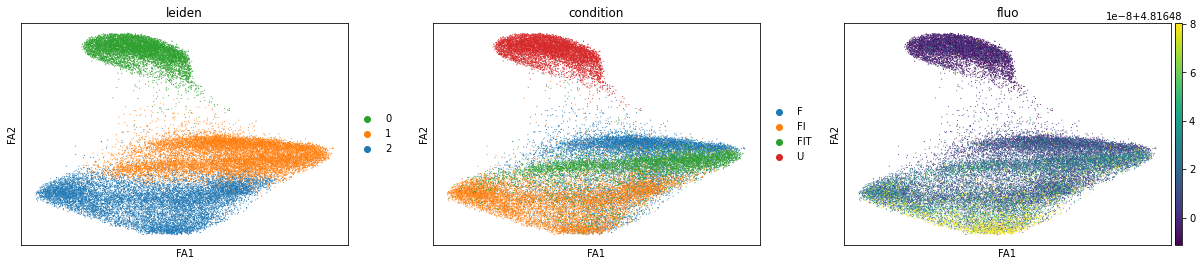

In [ ]:
adata = sc.read_h5ad('/content/gdrive/My Drive/SpaceM_GCollab/SpaceM_Paper_pseudotime_analysis/Hepatocytes_checkpoint.h5ad')
sc.pl.draw_graph(adata, color=['leiden', 'condition', 'fluo'])

Load variables

In [ ]:
def scale(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

def void2array(void):
    return pd.DataFrame(void).values

xy = np.copy(adata.obsm['X_draw_graph_fa'])
conditions = void2array(adata.obs['condition'].values).ravel()
conds_OI = ['U', 'F', 'FI', 'FIT']
fluo = adata.obs['fluo_data'].values
color = adata.obs['fluo'].values
leiden = np.array(adata.obs['leiden'].values)

Detect metabolite markers for each metabolic state


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


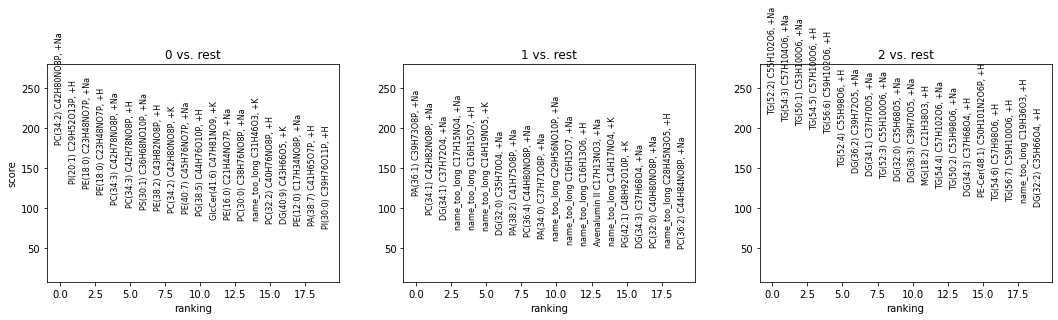

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', use_raw=False)
sc.pl.rank_genes_groups(adata, sharey=True)

Define pseudotime and illustrate on manifold

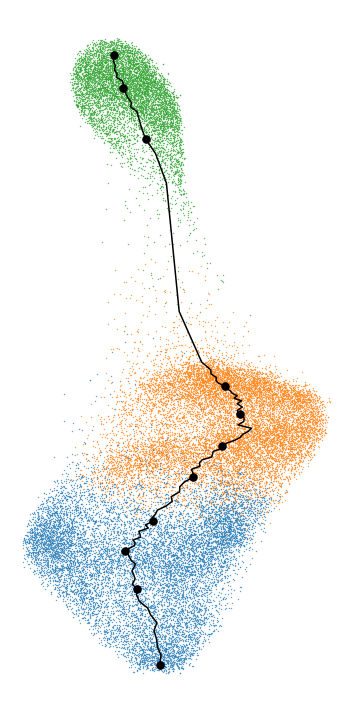

In [ ]:
clusters = adata.obs['leiden']
color = adata.uns['leiden_colors']

# The vertical axis is taken as the pseudotime trajectroy direction as it 
# captures the progression across the 3 metabolic states

pseudotime =  scale(xy[:, 1]) 
ind_pseudotime = np.argsort(pseudotime)
x_pdt = xy[ind_pseudotime, 0]
y_pdt = xy[ind_pseudotime, 1]
steps = 100
step_size = int(np.floor(len(x_pdt)/steps))
X = []
Y = []
for i in range(steps-1):
    X.append(np.mean(x_pdt[i * step_size:(i + 1) * step_size]))
    Y.append(np.mean(y_pdt[i * step_size:(i + 1) * step_size]))

fig = plt.figure(figsize=(5, 10))
ax = plt.subplot(111)
for i, cl in enumerate(np.unique(clusters)):
    x = xy[clusters == cl, 0]
    y = xy[clusters == cl, 1]
    c = color[i]
    plt.scatter(x, y, 0.1, c)
plt.plot(X, Y, '-', color='k')
plt.plot(X[::10], Y[::10], 'o', color='k', ms=7.5)
plt.plot(X[-1], Y[-1], 'o', color='k', ms=7.5)
plt.axis('off')
plt.tight_layout()


Display the proportion of the metabolic states for each condition

Text(0, 0.5, 'Cluster Proportions')

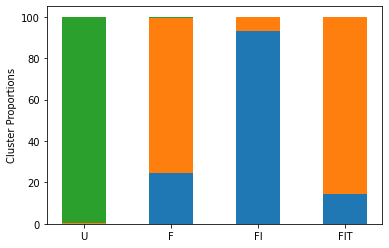

In [ ]:
prop_c0 = []
prop_c1 = []
prop_c2 = []

for c in conds_OI:
    cond_clusters = clusters[conditions == c]
    unique, counts = np.unique(cond_clusters, return_counts=True)
    counts_prop = 100 * counts / len(cond_clusters)
    prop_c0.append(counts_prop[0])
    prop_c1.append(counts_prop[1])
    prop_c2.append(counts_prop[2])

plt.figure()
width = 0.5
plt.bar(np.arange(4), prop_c2, width)
plt.bar(np.arange(4), prop_c1, width, bottom=prop_c2)
plt.bar(np.arange(4), prop_c0, width, bottom=np.array(prop_c2) + np.array(prop_c1))
plt.xticks(np.arange(4), conds_OI)
plt.ylabel('Cluster Proportions')

Display the trend of most specific metabolic markers across the pseudotime for each meatbolic state


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in power
  


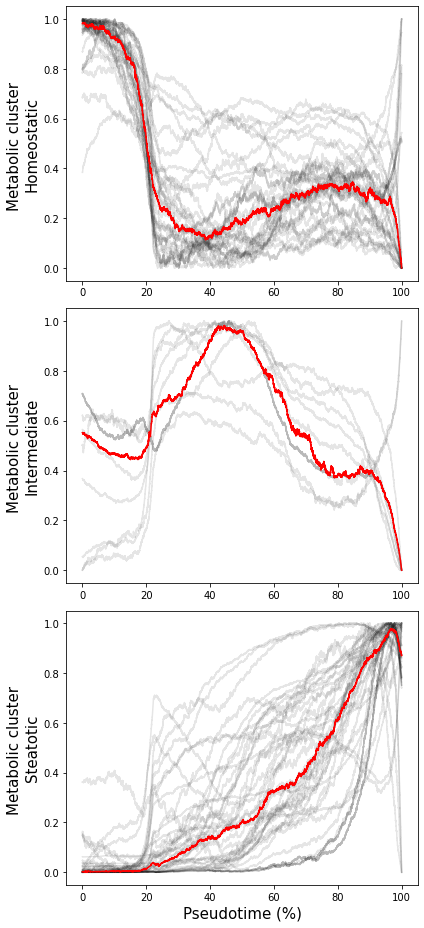

In [ ]:
score_threshold = 60  # Minimum t-statistic value for metabolites markers

ranking_results = adata.uns['rank_genes_groups']
scores = void2array(ranking_results['scores'])
names = void2array(ranking_results['names'])
n_clusters = scores.shape[1]
marker_genes = names[scores > score_threshold]
cluster_names = ['Homeostatic', 'Intermediate', 'Steatotic']

trends = {}
for i in range(n_clusters):
    trends[str(i)] = []

mol_lin = 10**(adata.X+1)
x = scale(range(len(pseudotime)))[::-1] # Invert the pseudotime s.t. it starts from the CTRL group up to the steatotic cells
for i, mg in enumerate(marker_genes):
    if mg in list(adata.var_names):
        metab_ind = list(adata.var_names).index(mg)
        df_ema = pd.DataFrame()
        df_ema.loc[:, 'y'] = np.log10(mol_lin[ind_pseudotime, metab_ind] +1)
        y = scale(df_ema['y'].ewm(span=1000, adjust=False).mean())
        ind = np.where(names == mg)
        # plt.subplot(1, n_clusters, ind[1][0] + 1)
        # plt.plot(x, y, 'k')

        trends[str(ind[1][0])].append(y.values)

plt.figure(figsize=(6, 13))
for i in range(n_clusters):
    plt.subplot(n_clusters, 1, i+1)
    for j in range(len(trends[str(i)])):
      plt.plot(x*100, trends[str(i)][j], 'k', alpha=0.1)
    plt.plot(x*100, np.median(trends[str(i)], axis=0), 'r', alpha=1)
    plt.ylabel(f'Metabolic cluster \n{cluster_names[i]}', fontsize=15)
plt.xlabel(f'Pseudotime (%)', fontsize=15)
plt.tight_layout()

Generate the metabolite marker matrix along the pseudotime


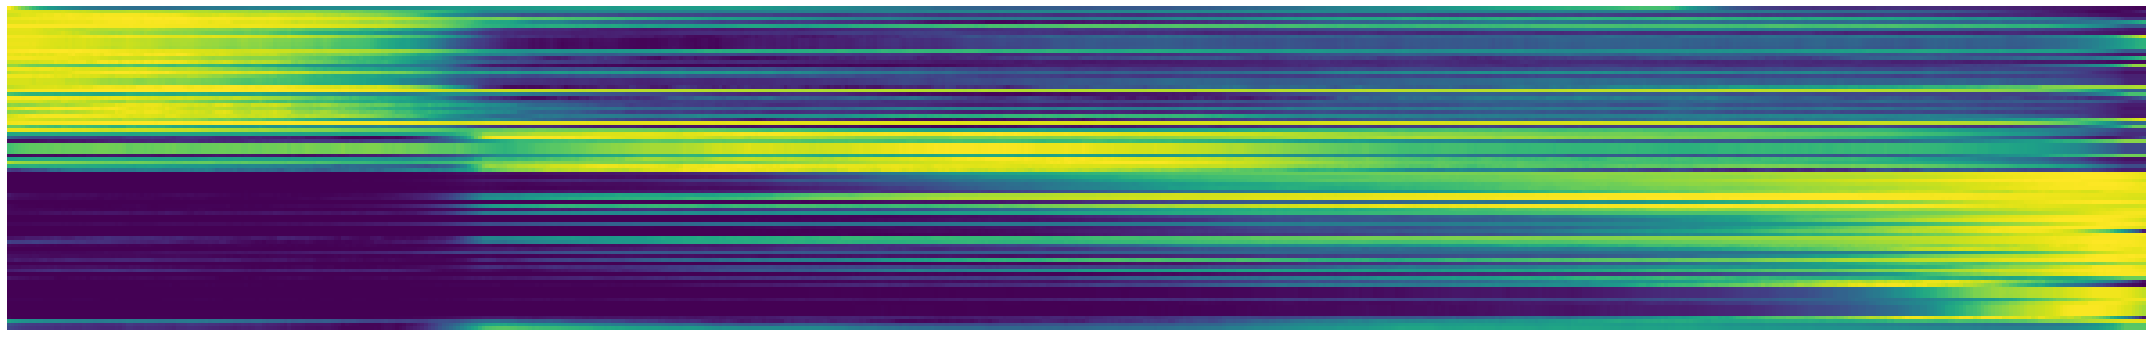

In [ ]:
marker_genes = np.zeros(1)
for i in range(n_clusters):
    marker_genes = np.append(marker_genes, names[:, i][scores[:, i] > score_threshold])
  
mol_lin = adata.raw.X
matrix = np.zeros([len(marker_genes), np.shape(adata)[0]])
for i, mg in enumerate(marker_genes):
    if mg in list(adata.var_names):
        metab_ind = list(adata.var_names).index(mg)
        df_ema = pd.DataFrame()
        df_ema.loc[:, 'y'] = np.log10(mol_lin[ind_pseudotime, metab_ind] +1)
        y = contrast(scale(df_ema['y'].ewm(span=1000, adjust=False).mean())[::-1], 1, 99)
    matrix[i, :] = y.values
plt.figure(figsize=(30,30))
plt.imshow(matrix[:, ::50], cmap='viridis')
plt.axis('off')
plt.tight_layout()

Show the metabolic states along the pseudotime

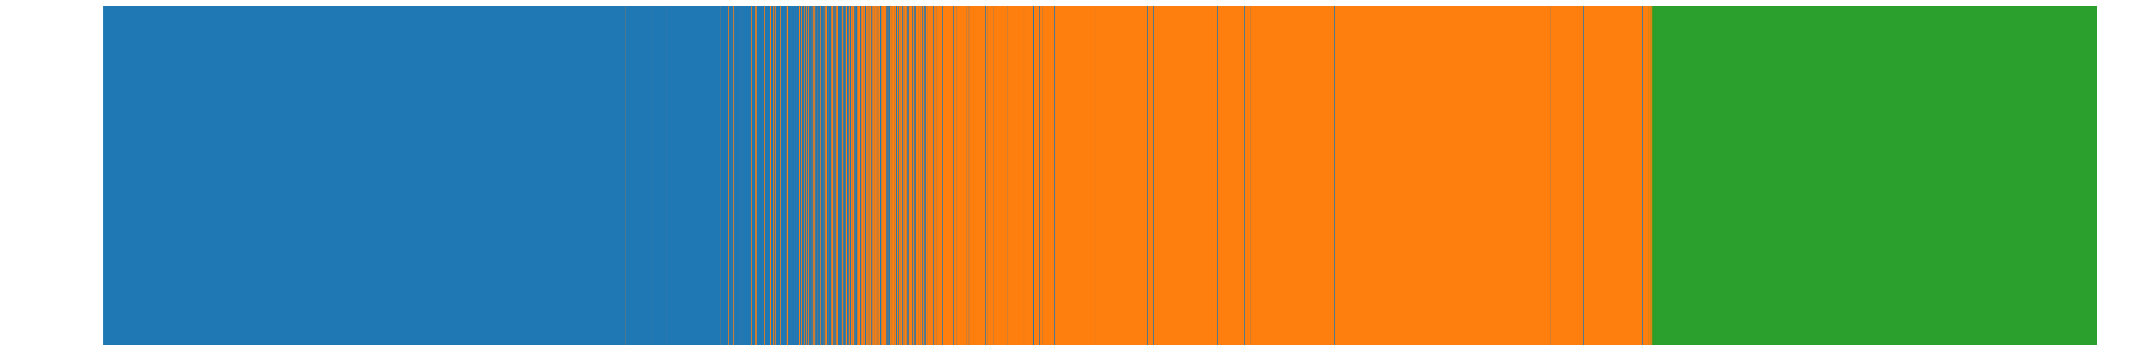

In [ ]:
leiden = np.array([int(i) for i in void2array(adata.obs.leiden.values).ravel()])
leiden_color = adata.uns['leiden_colors']
plt.figure(figsize=(30,5))
for i, leiden_i in enumerate(leiden[ind_pseudotime]):
    plt.axvline(x=i, color=leiden_color[leiden_i])
plt.axis('off')
plt.tight_layout()